<H1 align="center">Identificación de personas empleando una CycleGAN</H1>

<H5 align="right"> Jun 19, 2020</H5>

---
Inspirados por los grandes éxitos de las redes adversarias generativas (GANs) en las tareas de "traducción" de imágenes, en este trabajo se propone una nueva técnica de reconocimiento de la marcha mediante el uso de un modelo generativo cíclico para generar características de caminata robustas frente al cambio en la apariencia debido a variaciones en la indumentaria de las personas. \
El método propuesto se evalúo utilizando la base de datos CASIA-B, uno de los conjuntos de datos disponibles más extensos. Las pruebas se realizaron bajo las variaciones de vestimenta y condiciones de transporte. Los resultados experimentales muestran que el modelo implementado logra una tasa de clasificación correcta (CCR) sobresaliente.

Este notebook muestra la "traducción" de imagen a imagen sin emparejar usando una GAN condicional, como se describe en [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), también conocido como CycleGAN. El documento propone un método que puede capturar las características de un dominio de imagen y descubrir cómo estas características podrían traducirse a otro dominio de imagen, todo en ausencia de ejemplos de entrenamiento emparejados.

Las CycleGANs utilizan una función de pérdida cíclica para permitir el entrenamiento sin la necesidad de datos emparejados. En otras palabras, puede traducir de un dominio a otro sin un mapeo uno a uno entre el dominio de origen y el de destino.

Esto abre la posibilidad de realizar muchas tareas interesantes como la mejora de la foto, la coloración de la imagen, la transferencia de estilo, segmentación no supervizada, etc. Todo lo que necesita es el conjunto de datos de origen-source y destino-target.



# Preprocesamiento
Primero, vamos a clonar un repositorio el cual que contiene el conjunto de datos para entrenar y evaluar el modelo propuesto. [**CASIA-B**](http://www.cbsr.ia.ac.cn/english/Gait%20Databases.asp) es uno de los conjuntos de datos más grandes disponibles para evaluar las técnicas de reconocimiento de la marcha. Este conjunto de datos está compuesto por secuencias de caminata de 124 sujetos capturados en diferentes condiciones. Por cada sujeto en el dataset, existen 10 secuencias de caminata: 6 caminatas normales (nm), 2 llevando una maleta-cartera (bg) y 2 secuencias con abrigo (cl)

In [1]:
%%capture
!git clone https://gitlab.com/IsRaTiAl/gait.git
!unzip gait/GaitDatasetB-silh.zip

Luego, se creamos algunos directorios donde se extraerá el conjunto de datos (esto puede demorar ~ 5 minutos).

In [2]:
!mkdir -p CASIA/DatasetB/silhouettes                                             
!mkdir CASIA/sil                                                                  
!mkdir -p CASIA/predictions/to_source CASIA/predictions/to_target

import tarfile
from glob import glob
import shutil

from glob import glob
for i in range(1,125):
  if(i%10 ==0):
    print('Extracting Subject: '+str(i).zfill(3)+ '...')
  tf = tarfile.open('GaitDatasetB-silh/'+str(i).zfill(3)+'.tar.gz')
  tf.extractall('CASIA/DatasetB/silhouettes/')

Extracting Subject: 010...
Extracting Subject: 020...
Extracting Subject: 030...
Extracting Subject: 040...
Extracting Subject: 050...
Extracting Subject: 060...
Extracting Subject: 070...
Extracting Subject: 080...
Extracting Subject: 090...
Extracting Subject: 100...
Extracting Subject: 110...
Extracting Subject: 120...


## Normalización
En esta parte del código, las siluetas se extraen y normalizan, vea la figura a continuación. Se realiza una extracción de fondo simple para encontrar la silueta en cada imagen. Luego, se aplican algunas transformaciones de imagen, como el cambio de tamaño, el umbral y el recorte para normalizar nuestras imágenes y crear la representación de la imagen GEI (esto puede tomar ~ 15 min).
<figure>
<center>
<img src='https://gitlab.com/IsRaTiAl/gait/raw/master/Images/Image1.svg'/>
<figcaption>Normalization example</figcaption></center>
</figure>

In [3]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
import matplotlib.pyplot as plt


def GEI_generator(sil_file, size = 64,debug = False):
  lfiles = os.listdir(sil_file)
  lfiles.sort()
  stack_GEI = []
  if debug:
    plt.figure(figsize=(20,int(len(lfiles)/10)))
  for idimg, path in enumerate(lfiles):
    if debug: plt.subplot((len(lfiles)/15)+1,15, idimg+1)
    img = cv2.imread(sil_file+path,0)
    # Determinamos los contornos en cada imagen
    contours1,_ = cv2.findContours(img.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img,contours1,-1,255,-1)
    # Si existe algun contorno, lo normalizamos
    if (len(contours1)>0):
      # Determinamos la posición de cada contorno y lo extraemos de la imagen
      ncoun= np.concatenate(contours1)[:,0,:]
      x1, y1 = np.min(ncoun,axis=0)
      x2, y2 = np.max(ncoun,axis=0)
      silhouette = img[y1:y2,x1:x2]

      # Norm
      factor = size/max(silhouette.shape)
      height = round(factor*silhouette.shape[0])
      width = round(factor*silhouette.shape[1])
      if(height>width):
        nor_sil = cv2.resize(silhouette,(width,height))
        # We add a background of the shape size x size
        portion_body = 0.3  # We take the upper part of the body to center the image and avoid the legs
        moments = cv2.moments(nor_sil[0:int(nor_sil.shape[0]*portion_body),])
        w = round(moments['m10']/moments['m00'])
        background = np.zeros((size, size))
        shift = round((size/2)-w)
#         print('center:',w,' shift:',shift)
        if(shift<0 or shift+nor_sil.shape[1]>size): shift = round((size-nor_sil.shape[1])/2)
        background[:,shift:nor_sil.shape[1]+shift] = nor_sil
#         except:
#           print('Error')
        stack_GEI.append(background)
        if debug:
          plt.xticks([])
          plt.yticks([])
          plt.imshow(background,'gray')

  if stack_GEI == []:
    GEI = np.zeros((size, size))
    print('\tNo Files Found')
  else: 
    GEI = np.mean(np.array(stack_GEI),axis=0)
    
  return GEI, stack_GEI

Probamos nuestra función con el sujeto 33 de nuestro conjunto de datos en condiciones normales. Observe que estamos mostrando cada silueta en la secuencia, y al final de la secuencia, la imagen GEI correspondiente.

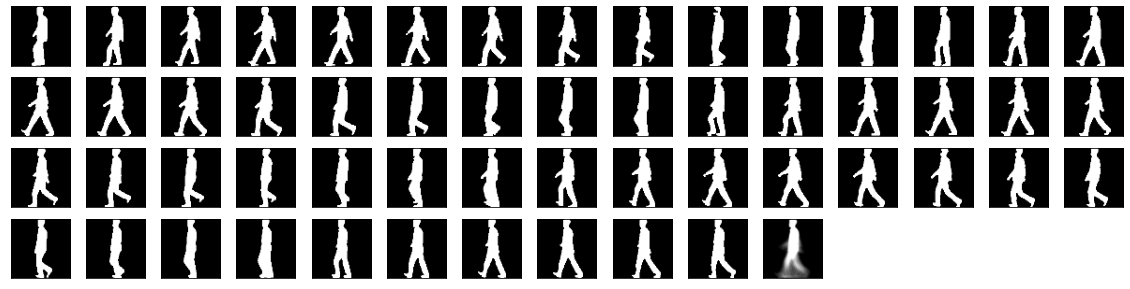

In [4]:
seq_dir = 'CASIA/DatasetB/silhouettes/001/nm-01/090/'
gGEI,_ = GEI_generator(seq_dir, 64, debug=True)
plt.imshow(gGEI, 'gray')

Como se puede ver arriba, nuestra función de normalización trabaja correctamente, así que procesemos las secuencias correspondientes a los 124 sujetos dentro del conjunto de datos. Esta es una iteración que recorre todos las secuencias de los sujetos, por lo que podría tomar 10 minutos procesar todas las secuencias.

In [5]:
from IPython.display import clear_output
import numpy as np
import cv2
import os
from os import listdir
from glob import glob
import time
t0 = time.clock()

# Definomos la direccion de las imagenes
data_base = 'CASIA'
data_set = 'DatasetB'
data_set_rep = 'sil'
directorio = 'silhouettes'
condition = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
# views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
views = np.array(['090'])
formato = '.png'
slash='/'

altura_maxima = 64
    
## subject
for subject in range(1,125):
  subject = str(subject).zfill(3)
  # Create the directory
  directory_sub = data_base+slash+data_set_rep+slash+subject;
  if not os.path.exists(directory_sub):
    os.makedirs(directory_sub)

## Iterate through condition
  for i in range(len(condition)):
    directory_condition = data_base+slash+data_set_rep+slash+subject+slash+condition[i];
    if not os.path.exists(directory_condition):
      os.makedirs(directory_condition)
    for view in views:
      directory_angle = directory_condition +'/'+ view
      if not os.path.exists(directory_angle):
        os.makedirs(directory_angle)

## view
    for view in views:
      rep_sil = data_base+slash+data_set+slash+directorio+slash+subject+slash+condition[i]+slash+view+slash
      save_sil = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash
      
      print('\r','Sujeto :',subject,' Condicion: ',condition[i],' Vista',view, end='')
#       clear_output(wait=True)
      GEI,_ = GEI_generator(rep_sil,size=altura_maxima)
      # Guardamos las GEI
      cv2.imwrite(save_sil+'0.png',GEI)      
      if cv2.waitKey(1) & 0xff==27:
        break

 Sujeto : 124  Condicion:  nm-06  Vista 090

## Visualización 
Visualicemos algunas imágenes del conjunto de datos.

In [6]:
import matplotlib.pyplot as plt

def plot_subject(subjects, image, sviews, scondition,name):
  plt.figure(figsize=(1.4*len(subjects),1.6*len(scondition)))
  figu = 1
  for i, cond in enumerate(scondition):
    for j, subject in enumerate(subjects):
      plt.subplot(len(scondition), len(subjects), figu)
      path = ('/').join([data_base, data_set_rep, subject, cond, sviews, image+'.png'])
      plt.imshow(cv2.imread(path,0),cmap='gray')
      plt.xticks([])
      plt.yticks([])
      if(j==0):
        plt.ylabel(cond)
      if(i==len(scondition)-1):
        plt.xlabel(subject)
      figu +=1
  plt.subplots_adjust(wspace=0.05, hspace=0.01)
  plt.savefig(name+'.png')

A continuación, se muestra las GEIs de los primeros 15 sujetos del dataset. Como se puede observar, la variación en la vestimenta puede afectar considerablemente la silueta de una persona.

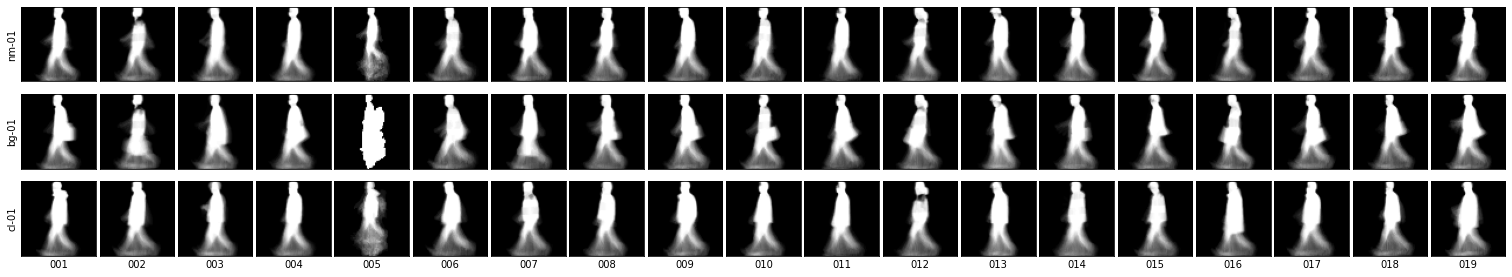

In [7]:
subject = [str(i).zfill(3) for i in range(1,20)]
scondition = np.array(['nm-01','bg-01','cl-01'])
sviews = '090'     
plot_subject(subject,'0',sviews,scondition,'Original_GEI')

# Cycle GAN
Empezamos importando algunas librerías útiles para deep learning, manejo de archivos, gráficos, etc.

In [8]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Dividiendo los datos 
Para entrenar el modelo, es necesario organizar los datos. Por lo tanto, vamos a establecer los GEI con cambios de vestimenta y variaciones de transporte como la fuente (source) y los GEI de la marcha normal (vista lateral) como el objetivo (target) para los primeros 62 sujetos, como se muestra en la figura abajo.
<figure>
<center>
<img src='https://gitlab.com/IsRaTiAl/CycleGAN/raw/master/images/Split_CycleGAN.svg' width="200%" height="200%"/>
<figcaption>Imágenes de fuente y objetivo</figcaption></center>
</figure>


In [9]:
# import numpy as np
# from os import listdir
# import cv2
# import os
# from glob import glob
# import time
# t0 = time.clock()
# import matplotlib.pyplot as plt

# Definomos la direccion de las imagenes
data_base = 'CASIA'
data_set_rep = 'sil'
condition = np.array(['bg-01','bg-02','cl-01','cl-02','nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'])
views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])  
formato = '.png'
visualize = 0
target_view = ['090']

source_list = []
target_list = []
## subject
for subject in range(1,63):
  print('\rSubject:',subject,end='')
#   clear_output(wait=True)
  subject = str(subject).zfill(3)

  for view in views:
    if view in target_view:
      for con in condition:
        rep_sil = '/'.join([data_base, data_set_rep, subject, con, view, '0.png'])
        if (con in condition[:4]):
          source_list.append(rep_sil)
        # GEI = cv2.imread(rep_sil,0)
        if (con in condition[4:]):
          target_list.append(rep_sil)

Subject: 62

Dividimos los datos y mostramos la cantidad de imágenes por grupo:


In [10]:
np.random.seed(23)                                                              # Nos permite repetibilidad en las muestras
np.random.shuffle(target_list)                                                  
np.random.shuffle(source_list)
ls_train_source = source_list[:round(len(source_list)*0.95)]
ls_test_source = source_list[round(len(source_list)*0.95):]
ls_train_target = target_list[:round(len(target_list)*0.95)]
ls_test_target = target_list[round(len(target_list)*0.95):]

print('Origen-Source: {}, \tTrain: {}, \ttest: {}'.format(len(ls_train_source)+len(ls_test_source),len(ls_train_source),len(ls_test_source)))
print('Destino-Target: {}, \tTrain: {}, \ttest: {}'.format(len(ls_train_target)+len(ls_test_target),len(ls_train_target),len(ls_test_target)))

Origen-Source: 248, 	Train: 236, 	test: 12
Destino-Target: 372, 	Train: 353, 	test: 19


## Aumento de datos
Definimos el tamaño de las imágenes y la cantidad de canales, así como la cantidad de imágenes a ser entrenadas por iteración.

In [141]:
BUFFER_SIZE = 100
BATCH_SIZE = 40
IMG_WIDTH = 64
IMG_HEIGHT = 64
CH = 1

En esta sección, definimos funciones que las utilizaremos para el aumento de datos:
- `random_crop`: Recorta las imágenes en función a los parámetros definidos a un inicio
- `normalize`: Normaliza los valores de los pixeles de cada imagen entre -1 y 1
- `randowm_jitter`: Crea un movimiento aleatorio en las imágenes de entrenamiento
- `load_image`: Recibe como parámetro la ruta de una imagen, la decodifica y transforma a una escala de grises
- `preprocess_image_train`: Ejecuta las funciones `load_image`, `random_jitter` y `normalize`, para luego retornar la imagen aumentada
- `preprocess_image_test`: Ejecuta las funciones `load_image` y `normalize`, para luego retornar la imagen original



In [142]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, CH])
  return cropped_image

def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  image = tf.image.resize(image, [int(IMG_WIDTH*1.01),  int(IMG_HEIGHT*1.01)], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = random_crop(image)
  return image

def load_image(path):
  img = tf.image.rgb_to_grayscale(tf.image.decode_png(tf.io.read_file(path),channels=3))
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  return img

def preprocess_image_train(path):
  image = load_image(path)
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(path):
  image = load_image(path)
  image = normalize(image)
  return image

Definimos dos funciones especiales (generadores de datos/data generators), que vamos a utilizar para entrenar el modelo, pero primero, probemos y veamos algunas muestras de origen-destino.

In [143]:
train_source = tf.data.Dataset.from_tensor_slices(ls_train_source)
train_source = train_source.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_target = tf.data.Dataset.from_tensor_slices(ls_train_target)
train_target = train_target.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_source = tf.data.Dataset.from_tensor_slices(ls_test_source)
test_source = test_source.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_target = tf.data.Dataset.from_tensor_slices(ls_test_target)
test_target = test_target.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

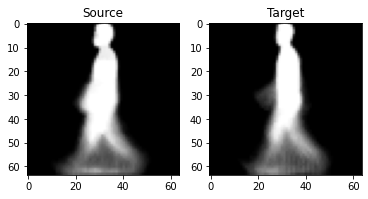

In [144]:
sample_source = next(iter(train_source))
sample_target = next(iter(train_target))


plt.subplot(121)
plt.title('Source')
plt.imshow(sample_source[0,...,0] * 0.5 + 0.5, cmap='gray')

plt.subplot(122)
plt.title('Target')
plt.imshow(sample_target[0,...,0] * 0.5 + 0.5, cmap='gray')

## Modelo CycleGAN 
Primero, vamos a definir los bloques básicos para construir nuestro modelo.
 
Empezamos definiendo la clase `InstanceNormalization` la cual emplea [instance normalization](https://arxiv.org/abs/1607.08022) en vez de [batch normalization](https://arxiv.org/abs/1502.03167). Produciendo de esta forma mejores resultados

In [145]:
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

A continuación, definimos los bloques de `downsample` y `upsample`, los cuales reducen e incrementan los mapas de características respectivamente. 
El bloque de `downsample` formado por los bloques `Conv2D => Batchnorm => LeakyRelu` toma como argumentos:
- filters: número de filtros
- size: tamaño del filtro
- norm_tupe: tipo de normalización; ya sea `batchnorm` o `instancenorm`. 
- apply_norm: si es verdadero, agrega la capa normalización

y retorna un bloque secuencial de reducción.


In [146]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, 
                                    size, 
                                    strides=2, 
                                    padding='same', 
                                    kernel_initializer=initializer,
                                    use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm': 
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm': 
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

El bloque de `upsample` formado por los bloques `Conv2DTranspose => Batchnorm => Dropout => Relu` toma como argumentos:
- filters: número de filtros
- size: tamaño del filtro
- norm_tupe: tipo de normalización; ya sea 'batchnorm' o 'instancenorm'. 
- apply_norm: si es verdadero, agrega la capa normalización

y retorna un bloque secuencial de aumento de tamaño.

In [147]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, 
                                             size, 
                                             strides=2,
                                             padding='same',
                                             kernel_initializer=initializer,
                                             use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.3))

  result.add(tf.keras.layers.ReLU())

  return result

Una vez que hemos definido los bloques de muestreo descendente y ascendente, podemos construir toda la arquitectura del generador y discriminador. Las arquitecturas empladas son similares a las propuestas en [Pix2Pix](https://arxiv.org/abs/1611.07004)

El generador empleado es una version modificada de la [U-NET](https://arxiv.org/abs/1611.07004). 

La función `unet_generator` formado por los 4 bloques `downsample` y 3 `upsample` toma como argumentos:
- output_channels: El número de canales de salida.
- norm_type: Tipo de normalización, para este trabajo se escogio `Instance normalization` siguiendo las recomendaciones de trabajos previos.

y retorna un modelo con la arquitectura de la U-NET, como se muestra en la figura.

<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Generator.svg' width="80%" height="80%"/></center>
</figure>
<center>Estructura del generador</center>


In [148]:
def unet_generator(output_channels, norm_type='batchnorm'):
  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),                           # (bs, 32, 32, 64)
      downsample(128, 4, norm_type),                                            # (bs, 16, 16, 128)
      downsample(256, 4, norm_type),                                            # (bs, 8, 8, 256)
      downsample(512, 4, norm_type),                                            # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),                                          # (bs, 2, 2, 512)
      # downsample(512, 4, norm_type),                                          # (bs, 1, 1, 512)
  ]

  up_stack = [
      # upsample(512, 4, norm_type, apply_dropout=True),                        # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),                        # (bs, 4, 4, 1024)
      upsample(256, 4, norm_type),                          # (bs, 8, 8, 512)
      upsample(128, 4, norm_type),                                              # (bs, 16, 16, 256)
      upsample(64, 4, norm_type),                                               # (bs, 32, 32, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels,
                                         4, 
                                         strides=2,
                                         padding='same', 
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()
  inputs = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Una vez que hemos definido la arquitectura del generador, podemos construir toda la arquitectura del discriminador. El modelo empleado es una version modificada de la [PatchGAN](https://arxiv.org/abs/1611.07004). 

La función `discriminator` formado por los 4 bloques `downsample` toma como argumentos:
- norm_type: Tipo de normalización, para este trabajo se escogio `Instance normalization` siguiendo las recomendaciones de trabajos previos.
- target: Variable booliana que define si las imágenes de entrenamiento estan emparejadas(True), o es un aprendizaje no supervizado (False)

y retorna un modelo con la arquitectura de la PatchGAN, como se muestra en la figura.

<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Discriminator.svg' width="80%" height="80%"/></center>
</figure>


In [149]:
def discriminator(norm_type='batchnorm', target=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 1], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])                                 # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)                                # (bs, 32, 32, 64)
  down2 = downsample(128, 4, norm_type)(down1)                                  # (bs, 16, 16, 128)
  down3 = downsample(256, 4, norm_type)(down2)                                  # (bs, 8, 8, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)                            # (bs, 10, 10, 256)
  conv = tf.keras.layers.Conv2D(512, 
                                4, 
                                strides=1, 
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)                      # (bs, 7, 7, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)                       # (bs, 9, 9, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (bs, 6, 6, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

Una CycleGAN requiere de 2 generadores (G y F) y 2 discriminadores (X y Y) los cuales se entrenaran adversariamente de forma ciclica. 

* El generador $G$ aprende a mapear la imagen de origen-source `X` a el destino-target `Y`. $(G: X -> Y)$
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Generator_G.svg' width="80%" height="80%"/></center>
</figure>

* El generador $F$ aprende a mapear la imagen de origen-source `Y` a el destino-target `X`. $(F: Y -> X)$
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Generator_F.svg' width="80%" height="80%"/></center>
</figure>

* El discriminador $D_X$ aprende a diferenciar entre la imagen origen-source `X` y la generada a partir del `Generador F`.
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Discriminator_X.svg' width="80%" height="80%"/></center>
</figure>
* El discriminador $D_Y$ aprende a diferenciar entre la imagen destino-target `Y` y la generada a partir del `Generador G`.
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Discriminator_Y.svg' width="80%" height="80%"/></center>
</figure>

La CycleGAN tiene el siguiente esquema
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/CycleGAN.svg' width="80%" height="80%"/></center>
</figure>



Empezamos instanciando nuestros generadores (G y F) y sus discriminadores (X y Y)

In [150]:
OUTPUT_CHANNELS = 1

generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

A continuación, empleamos imágenes de muestra para verificar que nuestros generadores se hayan instanciado correctamente y ver su inferencia inicial antes de entrenarlas.

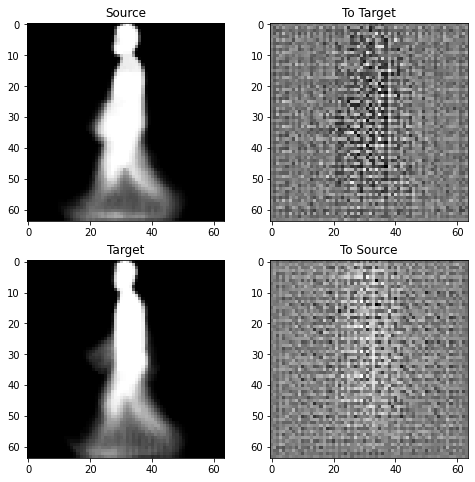

In [151]:
to_target = generator_g(sample_source)
to_source = generator_f(sample_target)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_source, to_target, sample_target, to_source]
title = ['Source', 'To Target', 'Target', 'To Source']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0,...,0] * 0.5 + 0.5, 'gray')
  else:
    plt.imshow(imgs[i][0,...,0] * 0.5 * contrast + 0.5, 'gray')
plt.show()

Realizamos un procedimiento similar para los discriminadores

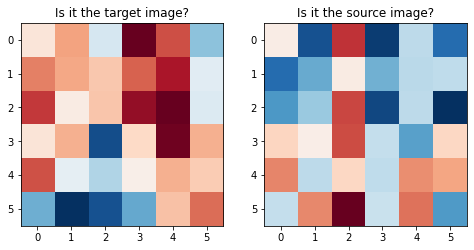

In [152]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is it the target image?')
plt.imshow(discriminator_y(to_target)[0, ..., 0], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is it the source image?')
plt.imshow(discriminator_x(to_source)[0, ..., 0], cmap='RdBu_r')

plt.show()

## Función de perdida

En una CycleGAN, no hay datos emparejados para entrenar, por lo tanto no hay garantía de que la entrada `x` y el par objetivo` y` sean significativos durante el entrenamiento. Por lo tanto, para garantizar que la red aprenda el mapeo correcto, los autores proponen la *cycle consistency loss*. Por otro lado, la perdida de los generadores y discriminadores es similar a la propuesta en [Pix2Pix](https://arxiv.org/abs/1611.07004)

In [153]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss

  # return total_disc_loss * 0.5
  return total_disc_loss

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

La *Cycle consistency losss* significa que el resultado debe estar cerca de la entrada original. Por ejemplo, si uno traduce una oración del inglés al español y luego la traduce nuevamente del español al inglés, entonces la oración resultante debe ser la misma que la oración original.

En la *cycle consistency loss*: 

* La imagen $X$ es mapeada por el generador $G$ que produce imagen generada $\hat{Y}$.
* Seguido, la imagen generada $\hat{Y}$ es mapeada por el generador $F$ que produce imagen cíclica $\hat{X}$.
* Finalmente, el error absoluto medio se calcula entre $X$ y $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Cycle-Consistency Loss1.svg' width="80%" height="80%"/></center>
</figure>


$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/Cycle-Consistency Loss2.svg' width="80%" height="80%"/></center>
</figure>

In [154]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

Como se muestra arriba, el generador $ G $ es responsable de mapear la imagen $ X $ a la imagen $ Y $. La pérdida de identidad dice que, si se alimentase la imagen $ Y $ al generador $ G $, este debería producir la imagen real $ Y $ o algo similar a la imagen $ Y $.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [155]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  # return LAMBDA * 0.5 * loss
  return 10*LAMBDA * loss

Inicializamos los optimizadores para los generadores y los discriminadores.

In [156]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Entrenamiento

Empezaremos definiendo la función `generate_images`, la cual toma un generador y una muestra y retorna la predicción.

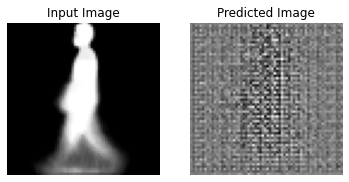

In [157]:
def generate_images(model, test_input, visualize=True):
  prediction = model(test_input)
  if visualize:
    plt.figure(figsize=(6, 6))

    display_list = [test_input[0,...,0], prediction[0,...,0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5, 'gray')
      plt.axis('off')
    plt.show()
  return prediction

_ = generate_images(generator_g, sample_source)

A continuación, definimos nuestro método para un paso de entrenamiento. Aunque el ciclo de entrenamiento parece complicado, consta de cuatro pasos básicos: 
* Predicción. 
* Cálculo de las pérdidas. 
* Cálculo de los gradientes utilizando la propagación hacia atrás (backpropagation). 
* Optimización de los parámetros empleando los gradientes del paso anterior.

In [158]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [159]:
# import datetime
# log_dir="logs/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [160]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss =  calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Finalmente, nos creamos una función que nos permita entrenar nuestro modelo un cierto número de épocas.

In [161]:
!rm CASIA/predictions/to_source/*
!rm CASIA/predictions/to_target/*

def train(epochs, past_epochs=0, visualize=True, save_images=True):
  for epoch in range(epochs):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_source, train_target)):
      train_step(image_x, image_y)
      print ('\r', 'Epoch:{}, step:{}/{}'.format(past_epochs+epoch+1,n,len(ls_train_source)/BATCH_SIZE), end='')
      n+=1

    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.

    if save_images:
      to_target = generate_images(generator_g, tf.expand_dims(sample_source[0],0), visualize= visualize)
      to_source = generate_images(generator_f, tf.expand_dims(sample_target[0],0), visualize= visualize)
      cv2.imwrite('CASIA/predictions/to_target/'+str(past_epochs+epoch+1).zfill(3)+'.png', 255*(to_target[0,...,0].numpy()+1)/2)
      cv2.imwrite('CASIA/predictions/to_source/'+str(past_epochs+epoch+1).zfill(3)+'.png', 255*(to_source[0,...,0].numpy()+1)/2)

    print ('\tTime taken for epoch {} is {} sec\n'.format(past_epochs+epoch + 1,round(time.time()-start,2)))

rm: cannot remove 'CASIA/predictions/to_source/*': No such file or directory
rm: cannot remove 'CASIA/predictions/to_target/*': No such file or directory


## Evaluación 
Ahora que la CycleGAN ha sido definida. Es necesario evaluar su rendimiento en nuevos datos.

Hemos utilizado las seis secuencias de caminata normales, dos secuencias con abrigo y dos secuencias que contienen caminar con una bolsa de los primeros 62 sujetos para entrenar la CycleGAN. 

Los 62 sujetos restantes se utilizarán como conjunto de prueba. En el conjunto de prueba, las primeras 4 secuencias de caminata normales de cada sujeto se colocan en el conjunto de la galería y las demás en el conjunto de la prueba como se muestra en la Tabla.
<figure>
<center><img src='https://gitlab.com/IsRaTiAl/CycleGAN/-/raw/master/images/ExperimentDesign.PNG' width="60%" height="60%"/></center>
</figure>

In [162]:
train_set = [1,63]
test_set = [63,125]
def transf(name):
  img = tf.image.rgb_to_grayscale(tf.image.resize((tf.image.decode_png(tf.io.read_file(name),channels=3)),(64, 64)))
  img = img[np.newaxis]/127.5-1
  pred = np.array(255*((generator_g(img,training = False)[0]+1)/2))
  return pred

Vamos a convertir todas las imágenes de secuencias de caminata con ropa y variaciones de apariencia a una caminata normal a una vista de 90° para los sujetos 63 a 124.

In [163]:
# import numpy as np
# from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time

t0 = time.clock()

# Definimos la direccion de las imagenes
data_base = 'CASIA'
data_set = 'DatasetB' 
data_set_rep = 'sil'
data_train = 'data'
directorio = 'silhouettes'	

train_   = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
views = ['090']	
# views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])

formato = '.png'


data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_
# print(data['train_'])

def transform_data(file_name,verbose=True, idrange= test_set):
  for subject in range(idrange[0],idrange[1]):
    subject = str(subject).zfill(3)
    if verbose:
#       print()
      print('\r', 'Subject: ',subject, end='')
    for dset in data:
  #     print(dset, ':',data[dset])
      condition = data[dset]
      for cond in condition:
        for view in views:
          # view = str(view*18).zfill(3)
          GEI_path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+'0.png'    #CASIA/sil/104/nm-04/090/0.png
          GEI_save_path = data_base+slash+data_set_rep+slash+subject+slash+cond+slash+view+slash+file_name+'.png'   #CASIA/sil/104/nm-04/090/4.png
          GEI = transf(GEI_path)
          cv2.imwrite(GEI_save_path,GEI)
  if verbose:
    print("\tTransform_data: ",str(time.clock()-t0))
  

Aquí, estamos organizando las imágenes generadas en conjuntos de galeria y prueba

In [164]:
# import numpy as np
# from numpy import ma
from os import listdir
import cv2
import os
from glob import glob
import time
# import skimage
# from skimage import transform
t0 = time.clock()

# Definomos la direccion de las imagenes
data_base = 'CASIA'
data_set = 'DatasetB' 
data_set_rep = 'sil'
data_train = 'data'
directorio = 'silhouettes'	
# views = np.array(['000','018','036','054','072','090','108','126','144','162','180'])
views = np.array(['090'])
train_ = np.array(['nm-01','nm-02','nm-03','nm-04'])
test_nm_ = np.array(['nm-05','nm-06'])
test_cl_ = np.array(['cl-01','cl-02'])
test_bg_ = np.array(['bg-01','bg-02'])
formato = '.png'


data = {}
data["train_"] = train_
data["test_nm_"] = test_nm_
data["test_cl_"] = test_cl_
data["test_bg_"] = test_bg_
# print(data['train_'])


def split_flat(file_name,verbose=True, idrange =test_set):
  t0 = time.clock()
  for view in views:
    if verbose: 
      print('View: ', str(view))
  #   view = str(view*18).zfill(3)
    for dset in data:
      if verbose: 
        print(dset, ':',data[dset])
      condition = data[dset]
      matriz  = []
      etiqueta = []
  #     motion_vector = []
      c1 =0
      for subject in range(idrange[0], idrange[1]):
        subject = str(subject).zfill(3)
  #       print('Subject: ', subject)
        for i in range(len(condition)):
          # Definimos el nombre de la imagen
          read_gei = data_base+slash+data_set_rep+slash+subject+slash+condition[i]+slash+view+slash+file_name+'.png'
          img = cv2.imread(read_gei,0)
  #         img[int(x1*0.12):int(x1*0.68),0:y1]=0

          try:
            matriz.append(img.flatten())
            etiqueta.append(int(subject))
          except:
            print('Error saving:', read_gei)

          if cv2.waitKey(1) & 0xff==27:
            break

      matriz = np.array(matriz)
      etiqueta = np.array(etiqueta)[np.newaxis].T
      directory_data = data_base+slash+data_train+slash+view+slash
      if not os.path.exists(directory_data):
          os.makedirs(directory_data)
      np.savetxt(directory_data+dset+'data.dat', matriz)
      np.savetxt(directory_data+dset+'target.dat', etiqueta)
      if verbose:
        print(dset,'data.dat-> ',matriz.shape)
        print(dset,'data.dat-> ',etiqueta.shape)

  cv2.destroyAllWindows()
  if verbose:
    print(str(time.clock()-t0))



En esta sección utilizamos un clasificador lineal para inferir la identidad de las nuevas muestras.

In [165]:
# import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm


def normalizacion(data):
	u = np.mean(data,axis=0)
	s = np.std(data,axis=0)
	data = (data - u)/s
	return (data,u,s)
def normalizacion2(data,u,s):
	data = (data - u) / s
	return data

datasets = ['test_nm_','test_bg_','test_cl_']
data_base = 'CASIA'
data_train = 'data'
slash = '/'

CCR_nm = np.zeros((11,11))
CCR_bg = np.zeros((11,11))
CCR_cl = np.zeros((11,11))

def test_model(iteration, CCR):
  for view_g,galery_view in enumerate(views):
    # Cargamos la base de datos
    carpeta = data_base+slash+data_train+slash+galery_view+slash

    trainX = np.loadtxt(carpeta+'train_data.dat')

    # Escalamos los datos
    scaler = StandardScaler()
    scaler.fit(trainX)
    trainX = scaler.transform(trainX)

    trainY = np.loadtxt(carpeta+'train_target.dat')

    _ ,componentes_original = trainX.shape

    # Aplicamos PCA
    pre = 0.9999
    pca = PCA(pre)
    pca.fit(trainX)
    componentes_PCA = pca.n_components_
    trainX = pca.transform(trainX)

    logisticRegr = LinearDiscriminantAnalysis(solver = 'lsqr',shrinkage=0.2)
    logisticRegr.fit(trainX, trainY)


    # Calculamos su score
    score = logisticRegr.score(trainX, trainY)
    print('Dataset: Train',' shape test: ',trainX.shape,' correcto: ',np.round(score,4), 'Angle:', galery_view)
    # Realizamos pruebas en los datasets de testeo
    for view_p,prove_view in enumerate(views):
      carpeta_p = data_base+slash+data_train+slash+prove_view+slash
      for i in range(len(datasets)):
        testX = np.loadtxt(carpeta_p+datasets[i]+'data.dat')
        testX = scaler.transform(testX)
        # testX = normalizacion2(testX,mean,st)
        testX = pca.transform(testX)
        testY = np.loadtxt(carpeta_p+datasets[i]+'target.dat')

        # Calculamos su score
        score = logisticRegr.score(testX, testY)
        certeza = logisticRegr.predict(testX)

        # Mostramos la matriz de confusion
        # print(confusion_matrix(certeza,testY))
        if(i==0):
          CCR_nm[view_g,view_p] = np.round(score*100,2)
          CCR['CCR_nm'].append(np.round(score*100,2))
        if(i==1):
          CCR_bg[view_g,view_p] = np.round(score*100,2)
          CCR['CCR_bg'].append(np.round(score*100,2))
        if(i==2):
          CCR_cl[view_g,view_p] = np.round(score*100,2)
          CCR['CCR_cl'].append(np.round(score*100,2))

      print('Prove view:', prove_view, '\tnm: ',CCR_nm[view_g,view_p],'\tbg: ',CCR_bg[view_g,view_p],'\tcl: ',CCR_cl[view_g,view_p])
    return CCR

  # print(str(iteration)+'T Test:1-62',np.round(CCR_nm.mean(),2),'-',np.round(CCR_bg.mean(),2),'-',np.round(CCR_cl.mean(),2))

In [166]:
CCR_nm1 = []; CCR_bg1 = []; CCR_cl1 = [];
CCR_train = {'CCR_nm':[], 'CCR_bg':[], 'CCR_cl':[]}
CCR_test = {'CCR_nm':[], 'CCR_bg':[], 'CCR_cl':[]}

In [167]:
total_epochs = 300
epochs_per_step = 20
CCR_nm1 = []; CCR_bg1 = []; CCR_cl1 = [];
for i in range(1, 1+int(total_epochs/epochs_per_step)):
  print('Epoch: {}'.format(i*epochs_per_step))
  train(epochs_per_step, (i-1)*epochs_per_step, visualize=False, save_images = False)
  transform_data(str(epochs_per_step*i), verbose=True, idrange = train_set)
  split_flat(str(epochs_per_step*i), verbose=False, idrange = train_set)
  CCR_train = test_model(str(epochs_per_step*i), CCR_train)

  transform_data(str(epochs_per_step*i), verbose=True, idrange = test_set)
  split_flat(str(epochs_per_step*i), verbose=False, idrange = test_set)
  CCR_test = test_model(str(epochs_per_step*i), CCR_test)

Epoch: 20
 Epoch:1, step:5/5.9	Time taken for epoch 1 is 20.48 sec

 Epoch:2, step:5/5.9	Time taken for epoch 2 is 2.16 sec

 Epoch:3, step:5/5.9	Time taken for epoch 3 is 2.16 sec

 Epoch:4, step:5/5.9	Time taken for epoch 4 is 2.18 sec

 Epoch:5, step:5/5.9	Time taken for epoch 5 is 2.19 sec

 Epoch:6, step:5/5.9	Time taken for epoch 6 is 2.18 sec

 Epoch:7, step:5/5.9	Time taken for epoch 7 is 2.19 sec

 Epoch:8, step:5/5.9	Time taken for epoch 8 is 2.2 sec

 Epoch:9, step:5/5.9	Time taken for epoch 9 is 2.19 sec

 Epoch:10, step:5/5.9	Time taken for epoch 10 is 2.21 sec

 Epoch:11, step:5/5.9	Time taken for epoch 11 is 2.19 sec

 Epoch:12, step:5/5.9	Time taken for epoch 12 is 2.23 sec

 Epoch:13, step:5/5.9	Time taken for epoch 13 is 2.22 sec

 Epoch:14, step:5/5.9	Time taken for epoch 14 is 2.2 sec

 Epoch:15, step:5/5.9	Time taken for epoch 15 is 2.23 sec

 Epoch:16, step:5/5.9	Time taken for epoch 16 is 2.22 sec

 Epoch:17, step:5/5.9	Time taken for epoch 17 is 2.22 sec

 Epoch

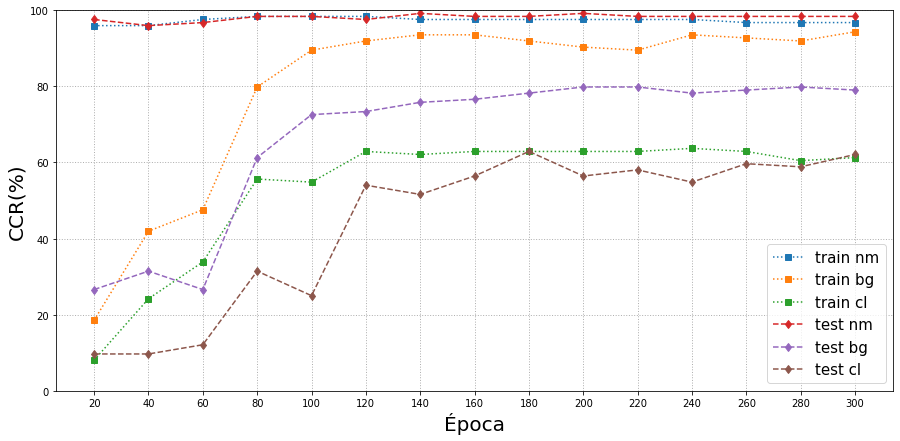

In [169]:
%matplotlib inline
plt.figure(figsize=(15,7))
plt.xticks(np.arange(20, total_epochs+1,epochs_per_step))
ls_epochs = list(range(0,total_epochs+1,epochs_per_step))[1:]
plt.plot(ls_epochs,CCR_train['CCR_nm'], label ='train nm', linestyle=":", marker='s')
plt.plot(ls_epochs,CCR_train['CCR_bg'], label ='train bg', linestyle=":", marker='s')
plt.plot(ls_epochs,CCR_train['CCR_cl'], label ='train cl', linestyle=":", marker='s')

plt.plot(ls_epochs,CCR_test['CCR_nm'], label ='test nm', linestyle="--", marker='d')
plt.plot(ls_epochs,CCR_test['CCR_bg'], label ='test bg', linestyle="--", marker='d')
plt.plot(ls_epochs,CCR_test['CCR_cl'], label ='test cl', linestyle="--", marker='d')

# plt.title('CCR(%) probe set\n Sujetos: 63-124')
plt.ylabel('CCR(%)', size = 20)
plt.xlabel('Época', size = 20)
plt.ylim([0,100])
plt.grid('minor',linestyle=':', linewidth=1)
plt.legend(prop={'size': 15})
plt.savefig("train_test.svg", bbox_inches='tight') 

In [170]:
import json
with open('train_full.json', 'w') as fp:
    json.dump(CCR_train, fp)
with open('test_full.json', 'w') as fp:
    json.dump(CCR_test, fp)

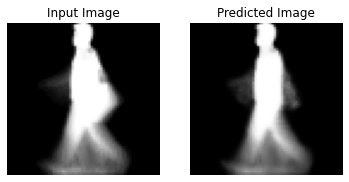

In [171]:
# Run the trained model on the test dataset
for inp in test_source.take(1):
  generate_images(generator_g, inp)

In [172]:
def plot_subject_epochs(subject, images, sviews, scondition,name):
  plt.figure(figsize=(1.4*len(images),1.6*len(scondition)))
  figu = 1
  for i, cond in enumerate(scondition):
    for j, image in enumerate(images):
      plt.subplot(len(scondition), len(images), figu)
      path = ('/').join([data_base, data_set_rep, subject, cond, sviews, str(image)+'.png'])
      plt.imshow(cv2.imread(path,0),cmap='gray')
      plt.xticks([])
      plt.yticks([])
      if(j==0):
        plt.ylabel(cond)
      if(i==len(scondition)-1):
        plt.xlabel(image)
      figu +=1
  plt.subplots_adjust(wspace=0.05, hspace=0.01)
  plt.savefig(name+'.png')

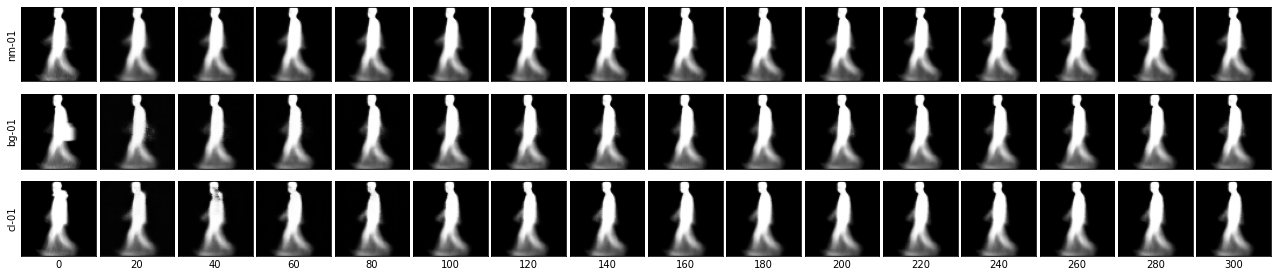

In [173]:
ls_epochs = list(range(0,total_epochs+1,epochs_per_step))
scondition = np.array(['nm-01','bg-01','cl-01'])
sviews = '090'     
plot_subject_epochs('001',ls_epochs,sviews,scondition,'GEI_through_train')

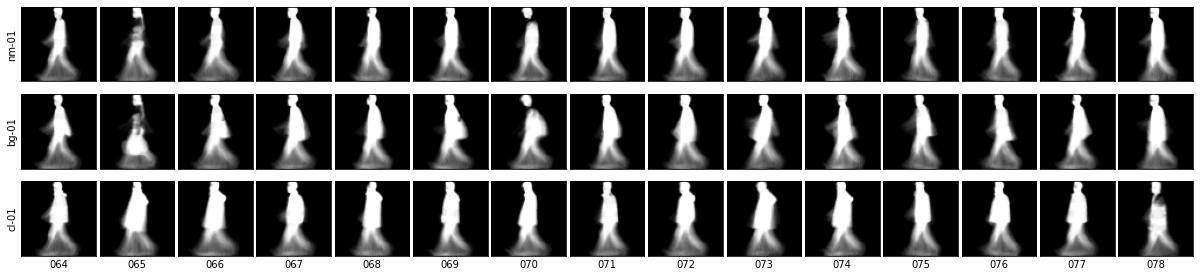

In [174]:
subject = [str(i).zfill(3) for i in range(64,64+15)]
scondition = np.array(['nm-01','bg-01','cl-01'])
sviews = '090'     
plot_subject(subject,'0',sviews,scondition,'Original_GEI_15')

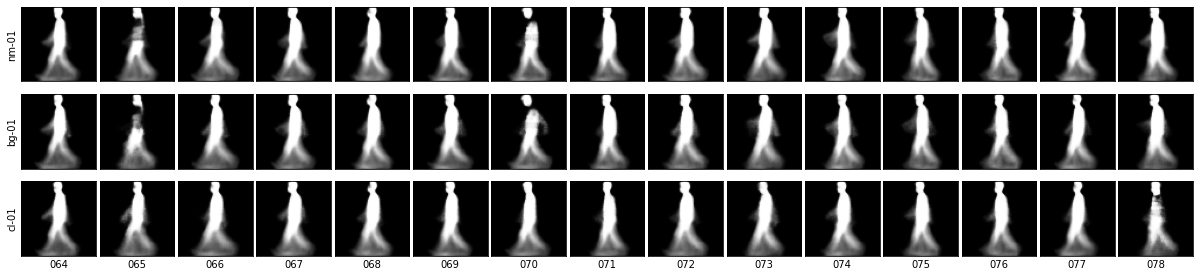

In [175]:
subject = [str(i).zfill(3) for i in range(64,64+15)]
scondition = np.array(['nm-01','bg-01','cl-01'])
sviews = '090'     
plot_subject(subject,'200',sviews,scondition,'Generated_GEI_15')

In [176]:
import numpy as np
import cv2

predictions = ['to_target','to_source']

for prediction in predictions:
  fourcc = cv2.VideoWriter_fourcc(*'XVID')
  out = cv2.VideoWriter(prediction+'.avi',fourcc, 5.0, (64,64))
  path = 'CASIA/predictions/'+prediction
  files = os.listdir(path)
  files.sort()
  for file in files:
    file_name = '/'.join([path,file])
    # print(file_name)
    # cv2.imread(file_name,0)
    frame = cv2.imread(file_name)
    # if ret==True:
        # write the flipped frame
    out.write(frame)
  # Release everything if job is finished
  out.release()

In [177]:
cv2.imwrite('sample_source.png',255*((sample_source[0,...,0].numpy()+1)/2))
cv2.imwrite('sample_target.png',255*((sample_target[0,...,0].numpy()+1)/2))

True